<a href="https://colab.research.google.com/github/O-E2/deep_learning/blob/main/deep_learning_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제 3
## Fashion MNIST
### 환경 설정 및 시드 고정

In [17]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.models import resnet18
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
from torchinfo import summary
import wandb

# 랜덤 시드 고정 (재현성 확보)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

# 디바이스 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if str(device) == 'cpu':
    print("CPU")
else:
    print("GPU Ready")

Device: cuda
GPU Ready


### 조기종료 class 정의

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
        # 몇 번 참을건지 설정
        self.patience = patience
        # 연속으로 개선이 없던 횟수
        self.counter = 0
        # 최소 개선 인정 값
        self.delta = delta
        # 최소 val loss
        self.val_loss_min = None

        # 체크포인트 저장 경로가 없으면 기본 경로 사용
        if checkpoint_file_path is None:
            checkpoint_file_path = os.path.join(os.getcwd(), "checkpoints")
        os.makedirs(checkpoint_file_path, exist_ok=True)

        # 모델 가중치를 저장할 파일 경로
        self.file_path = os.path.join(checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt")

    def check_and_save(self, new_validation_loss, model):
        # 학습을 멈출지 여부
        early_stop = False
        message = ""

        # 첫 번째 호출일 때: 기준 loss 설정 + 체크포인트 저장
        if self.val_loss_min is None:
            self.val_loss_min = new_validation_loss
            message = f'Start Monitoring (Initial Val Loss: {new_validation_loss:.5f})'
            self.save_checkpoint(new_validation_loss, model)
        # validation loss가 delta만큼 더 좋아졌을 때: 모델 저장 + 카운터 리셋
        elif new_validation_loss < self.val_loss_min - self.delta:
            message = f'Model Save (Val Loss: {self.val_loss_min:.5f} --> {new_validation_loss:.5f})'
            self.save_checkpoint(new_validation_loss, model)
            self.val_loss_min = new_validation_loss
            self.counter = 0
        # 개선이 없을 때: 카운터 증가, patience를 넘으면 early stopping
        else:
            self.counter += 1
            message = f'Patience: {self.counter}/{self.patience}'
            if self.counter >= self.patience:
                early_stop = True
                message += " \n Early Stopp!"

        return message, early_stop

    def save_checkpoint(self, val_loss, model):
        # 현재 모델 가중치를 파일로 저장
        torch.save(model.state_dict(), self.file_path)
print("단순 클래스임으로 출력이 나오지 않습니다..")

단순 클래스임으로 출력이 나오지 않습니다..


### 데이터 정규화 및 데이터 로더 설정
### 문제1 - 정규화를 위한 mean과 std 값 찾기

In [19]:
def get_fashion_mnist_data(batch_size):
    # 데이터 경로 설정
    data_path = os.path.join(os.getcwd(), "data", "j_fashion_mnist")

    # ToTensor만 적용한 임시 데이터셋
    temp_transform = transforms.ToTensor()
    temp_dataset = datasets.FashionMNIST(
        data_path, train=True, download=True, transform=temp_transform
    )

    # Train : Val 분할
    temp_train, _ = random_split(temp_dataset, [55_000, 5_000])

    # 텐서로 모아서 계산
    imgs = torch.stack([img for img, _ in temp_train], dim=0)
    mean_val = imgs.mean().item()
    std_val = imgs.std().item()

    print(f"  Calculated Mean: {mean_val:.4f}")
    print(f"  Calculated Std : {std_val:.4f}")

    # Train: 정규화 + 데이터 증강
    train_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean_val,), (std_val,)),
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
    ])

    # Val: 정규화만 적용
    val_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean_val,), (std_val,)),
    ])

    full_dataset = datasets.FashionMNIST(
        data_path, train=True, download=True, transform=train_tf
    )

    train_set, val_set = random_split(full_dataset, [55_000, 5_000])

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, num_workers=2, pin_memory=True
    )

    # 계산된 mean/std도 함께 반환
    return train_loader, val_loader, train_tf, val_tf, mean_val, std_val


def get_fashion_mnist_test_data(batch_size, mean_val, std_val):
    data_path = os.path.join(os.getcwd(), "data", "j_fashion_mnist")

    # Test 정규화
    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean_val,), (std_val,)),
    ])

    test_set = datasets.FashionMNIST(
        data_path, train=False, download=True, transform=test_tf
    )

    test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=2)

    return test_loader, test_tf


BATCH_SIZE = 128

# Train 데이터 로드 및 통계 계산
train_loader, val_loader, train_tf, val_tf, calc_mean, calc_std = get_fashion_mnist_data(BATCH_SIZE)

# Test 데이터 로드 (Train에서 계산된 통계치 전달)
test_loader, test_tf = get_fashion_mnist_test_data(BATCH_SIZE, calc_mean, calc_std)

print("-" * 50)
print(f"Train Samples: {len(train_loader.dataset)}")
print(f"Valid Samples: {len(val_loader.dataset)}")
print(f"Test  Samples: {len(test_loader.dataset)}")

# 첫 배치의 입력 텐서 모양 확인
first_batch = next(iter(train_loader))
print(f"Input Shape: {first_batch[0].shape}")  # (Batch, 1, 28, 28)


  Calculated Mean: 0.2856
  Calculated Std : 0.3527
--------------------------------------------------
Train Samples: 55000
Valid Samples: 5000
Test  Samples: 10000
Input Shape: torch.Size([128, 1, 28, 28])


### ResNet 모델

In [20]:
def get_resnet_fashion_mnist(num_classes=10):
    # torchvision에서 ResNet-18 기본 모델 불러오기
    # 사전학습 가중치는 사용하지 않으므로 weights=None
    model = resnet18(weights=None)

    # 입력 채널을 1로 변경 (FashionMNIST는 흑백 이미지)
    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=3,
        stride=1,
        padding=1,
        bias=False,
    )

    # 28x28 작은 입력에서는 초반에 해상도를 과하게 줄이지 않도록 maxpool 제거
    model.maxpool = nn.Identity()

    # 마지막 FC 레이어를 클래스 개수에 맞게 수정
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

# 모델 생성 및 요약 출력
model = get_resnet_fashion_mnist(num_classes=10).to(device)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 28, 28]           576
├─BatchNorm2d: 1-2                       [1, 64, 28, 28]           128
├─ReLU: 1-3                              [1, 64, 28, 28]           --
├─Identity: 1-4                          [1, 64, 28, 28]           --
├─Sequential: 1-5                        [1, 64, 28, 28]           --
│    └─BasicBlock: 2-1                   [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                  [1, 64, 28, 28]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-3                    [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-4                  [1, 64, 28, 28]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-6                    [1, 64, 28, 28]           --
│  

### 학습 및 검증 함수 로직 정의

In [21]:
def train_one_epoch(model, loader, transform, criterion, optimizer, device):
    model.train()  # 학습 모드로 전환 (Dropout, BatchNorm 등이 학습 모드로 동작)
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        # 배치를 지정된 device로 이동
        images, labels = images.to(device), labels.to(device)

        # 이전 반복에서 남은 gradient 초기화
        optimizer.zero_grad()

        # 순전파(forward)
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 역전파(backward)로 gradient 계산
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

        # 예측값 계산 (가장 큰 logit의 인덱스를 클래스 예측으로 사용)
        _, predicted = outputs.max(1)

        # 전체 개수와 정답 개수 누적
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # 평균 손실과 정확도(%) 반환
    return running_loss / len(loader), 100.0 * correct / total


def evaluate(model, loader, transform, criterion, device):
    model.eval()  # 평가 모드로 전환
    running_loss, correct, total = 0.0, 0, 0

    # 평가 시에는 gradient 계산 비활성화
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), 100.0 * correct / total
print("단순 함수 정의이기에 출력이 나오지 않습니다..")

단순 함수 정의이기에 출력이 나오지 않습니다..


### 학습 - 파라미터 정의 포함
### 문제 2 데이터로 모델 학습시키기


*   Batch Size	128
*   Initial Learning Rate	0.001
* Optimizer	AdamW
* Weight Decay	0.0001
* Early Stop Patience	5
* Normalization Type	Batch Normalization
* Dropout Rate	사용 안 함
* Data Augmentation	RandomCrop, HorizontalFlip
### Wandb URL
* https://wandb.ai/cyun0407-korea-university-of-technology-and-education/FashionMNIST_Report_Final/workspace?nw=nwusercyun0407

In [27]:
config = {
    "epochs": 20,
    "batch_size": 128,
    "learning_rate": 0.001,
    "patience": 5,
    "architecture": "ResNet18_Custom"
}

# WandB 초기화 (이전에 열려 있던 run 정리)
try:
    wandb.finish()
except:
    pass
wandb.init(
    mode="online",
    project="FashionMNIST_Report_Final",
    config=config,
)
wandb.define_metric("epoch")
wandb.define_metric("Loss/*", step_metric="epoch")
wandb.define_metric("Accuracy/*", step_metric="epoch")

# 손실함수, 옵티마이저, 스케줄러 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=config['learning_rate'],
                        weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config['epochs']
)

# Early Stopping 설정
run_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
early_stopper = EarlyStopping(
    patience=config['patience'],
    project_name="resnet",
    run_time_str=run_str
)

print(f"\nStart Training (Max Epochs: {config['epochs']})...")

for epoch in range(config['epochs']):
    # 한 epoch 학습 / 검증
    train_loss, train_acc = train_one_epoch(
        model, train_loader, train_tf, criterion, optimizer, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, val_tf, criterion, device
    )

    scheduler.step()
    lr = optimizer.param_groups[0]['lr']

    # 콘솔 로그
    print(
        f"[Epoch {epoch+1:02d}] "
        f"Train: {train_loss:.4f} ({train_acc:.2f}%) | "
        f"Val: {val_loss:.4f} ({val_acc:.2f}%) | "
        f"LR: {lr:.6f}"
    )

    # wandb 로그
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })

    # Early Stopping 체크
    msg, stop = early_stopper.check_and_save(val_loss, model)
    print(f"   -> {msg}")

    if stop:
        break

wandb.finish()



Start Training (Max Epochs: 20)...
[Epoch 01] Train: 0.1869 (93.24%) | Val: 0.2252 (91.78%) | LR: 0.000994
   -> Start Monitoring (Initial Val Loss: 0.22523)
[Epoch 02] Train: 0.1762 (93.58%) | Val: 0.2041 (92.76%) | LR: 0.000976
   -> Model Save (Val Loss: 0.22523 --> 0.20409)
[Epoch 03] Train: 0.1682 (93.87%) | Val: 0.1933 (92.80%) | LR: 0.000946
   -> Model Save (Val Loss: 0.20409 --> 0.19335)
[Epoch 04] Train: 0.1613 (94.25%) | Val: 0.1917 (92.88%) | LR: 0.000905
   -> Model Save (Val Loss: 0.19335 --> 0.19174)
[Epoch 05] Train: 0.1548 (94.38%) | Val: 0.1918 (92.92%) | LR: 0.000854
   -> Patience: 1/5
[Epoch 06] Train: 0.1436 (94.66%) | Val: 0.1941 (93.04%) | LR: 0.000794
   -> Patience: 2/5
[Epoch 07] Train: 0.1381 (95.00%) | Val: 0.1779 (93.62%) | LR: 0.000727
   -> Model Save (Val Loss: 0.19174 --> 0.17793)
[Epoch 08] Train: 0.1311 (95.23%) | Val: 0.1674 (94.08%) | LR: 0.000655
   -> Model Save (Val Loss: 0.17793 --> 0.16743)
[Epoch 09] Train: 0.1221 (95.54%) | Val: 0.1780 (93.

train_acc,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇██
train_loss,█▇▇▇▆▆▅▅▅▄▄▃▃▂▂▂▁▁
val_acc,▁▃▃▄▄▄▆▇▆▆▇▇█▇█▇██
val_loss,█▆▅▄▄▅▃▂▃▂▃▃▁▄▁▄▃▃
train_acc,98.08909
train_loss,0.05334
val_acc,94.64
val_loss,0.18108


### test 데이터로 성능평가
### 문제 3 학습된 모델로 테스트 데이터 Accuracy 확인하기

In [28]:
# 학습 중 가장 성능이 좋았던 모델 가중치 로드
print("Loading best model")
try:
    model.load_state_dict(torch.load(early_stopper.file_path))
    print("success")
except Exception as e:
    print(f"Error: {e}")

# 테스트 세트 평가
test_loss, test_acc = evaluate(model, test_loader, test_tf, criterion, device)
print(f"\n Test Accuracy: {test_acc:.2f}% (Loss: {test_loss:.4f})")


Loading best model
success

 Test Accuracy: 94.10% (Loss: 0.1886)


### 문제 4 샘플 테스트 데이터 분류 예측 결과 확인하기


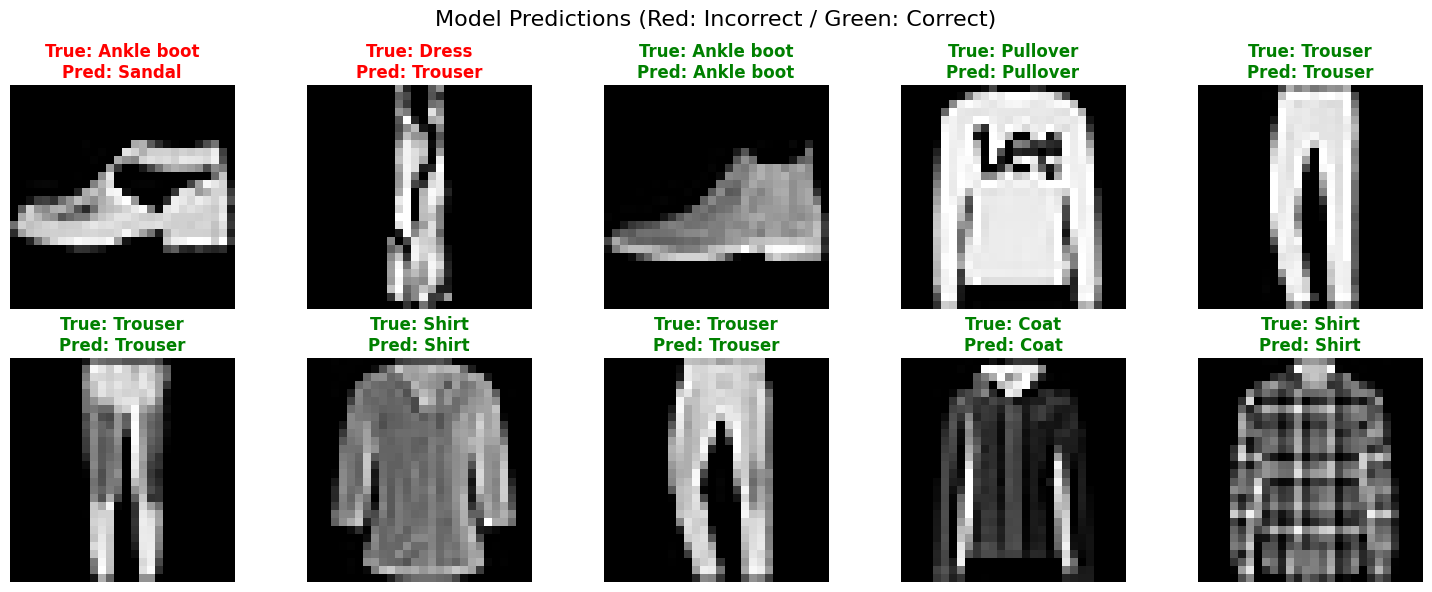

In [29]:
# [Cell 8] Visualization & Failure Analysis
def visualize_results(model, loader):
    # 클래스 이름 매핑 (FashionMNIST)
    class_names = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

    model.eval()
    correct_samples, incorrect_samples = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                # 최소 2개 오답, 8개 정답만 수집
                if len(incorrect_samples) >= 2 and len(correct_samples) >= 8:
                    break

                # 시각화를 위해 정규화 원복
                img = images[i].cpu() * 0.3530 + 0.2860
                img = torch.clamp(img, 0, 1)

                info = (img, labels[i].item(), preds[i].item())
                if labels[i] == preds[i]:
                    correct_samples.append(info)
                else:
                    incorrect_samples.append(info)

            if len(incorrect_samples) >= 2 and len(correct_samples) >= 8:
                break

    # 오답 2개 + 정답 8개를 하나의 리스트로 구성
    final_samples = incorrect_samples[:2] + correct_samples[:8]

    fig = plt.figure(figsize=(15, 6))
    for i, (img, true_lbl, pred_lbl) in enumerate(final_samples):
        ax = fig.add_subplot(2, 5, i + 1)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')

        # 오답은 빨간색, 정답은 초록색 제목
        color = 'green' if true_lbl == pred_lbl else 'red'
        title = f"True: {class_names[true_lbl]}\nPred: {class_names[pred_lbl]}"
        ax.set_title(title, color=color, fontweight='bold')

    plt.suptitle("Model Predictions (Red: Incorrect / Green: Correct)", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_results(model, test_loader)


좁은 폭과 중앙의 세로선이라는 두 가지 특징을 조합하여 이를 두 다리가 있는 바지로 잘못 예측한 것 같다.

이 신발은 부츠와 샌들의 특징을 모두 가지고 있다. 모델은 학습 과정에서 막혀 있음 = 부츠, 뚫려 있음 = 샌들이라는 패턴을 강하게 학습했을 것이며, 이 이미지에서는 뚫려 있는 특징에 더 큰 가중치를 두어 Sandal로 판단했을 것이다.

### 기술적 고찰
잘못 분류한 사례를 통해 이미지의 특징을 기반을 예측한다는 것을 알게 되었다.
코드적인 부분에서는 기존 ResNet의 입력값이 224 * 224 이여서 부적합하다는 것을 알았다 또한 초기 conv layer를 수정해보며 ResNet에 대한 이해도가 올라갔다.

### 숙제 후기
ResNet 구조를 직접 코드로 짜보고 torchinfo로 들여다보니까 구조가 확 와닿아서 좋았다. 무엇보다 단순히 정확도 94% 찍고 끝나는 게 아니라, 모델이 도대체 '왜' 틀렸는지 이미지를 뜯어보는 과정이 제일 유익했다. 28x28 픽셀 뭉개진 거 보고 나도 헷갈리는데 모델이 이 정도 맞추는 거 보면 대단한 거 같다.
wandb에서 public 설정하는 게 꼭꼭 숨어있어서 찾는데 애먹었다.